In [1]:
from coppertop.core import ensurePath, unload
'/Users/david/repos/github/DangerMouseB/coppertop/src/std' >> ensurePath       # <= set this to your path
'/Users/david/repos/github/DangerMouseB/examples/src/dm' >> ensurePath       # <= set this to your path
from importlib import reload

See README.md for notes on usage of coppertop.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

In [3]:
from coppertop.pipe import *
from coppertop.core import RR, DD, HH, LL, TT #, SS for str
from bones.lang.metatypes import BType
from ribs.types import T, T1, T2, T3, num, txt
from dm.core import format, kvs, join, values, _, inject, each, keys, values, typeOf, at
from dm.core.maths import max, min
from dm.core.types import adhoc, pytuple, pylist
from dm.core.stats import logisticCDF
from dm.pmf import pmfMul, normalise, uniform, sequence, mean, PMF, L, to, CMF, toCmf, percentile
from dm.utils import formatStruct

In [4]:
formatPmf = formatStruct(_, 'PMF', '.3f', '.3f', ', ')
formatL = formatStruct(_, 'L', '.3f', '.3f', ', ')
formatCmf = formatStruct(_, 'L', '.3f', '.3f', ', ')

@coppertop
def _PP(x):
    print(x)
    return x

@coppertop
def PP(x):
    return x >> _PP

@coppertop
def PP(x, f):
    f(x) >> _PP
    return x

@coppertop
def PP(x:L):
    x >> formatL >> _PP
    return x

@coppertop
def PP(x:PMF):
    x >> formatPmf >> _PP
    return x

@coppertop
def PP(x:CMF):
    x >> formatCmf >> _PP
    return x

<br>

#### Bayes Refresher

from PROP 3
$$
\begin{align}
\mathbf{P}\left(B \cap A\right) = \mathbf{P}\left(B\mathbin{\vert}A\right)\cdot \mathbf{P}\left(A\right)\\
\end{align}
$$

and obviously
$$\mathbf{P}(A \cap B) = \mathbf{P}(B \cap A)$$

so
$$
\begin{align}
\mathbf{P}( A\mathbin{\vert}B) \cdot \mathbf{P}(B)=\mathbf{P}(B\mathbin{\vert}A)\cdot \mathbf{P}(A)
\end{align}
$$

aka
$$
\begin{align}
\mathbf{P}( hypothesis\mathbin{\vert}data) \cdot \mathbf{P}(data)=\mathbf{P}(data\mathbin{\vert}hypothesis)\cdot \mathbf{P}(hypothesis)
\end{align}
$$

Comtemporaneous (look it up) version, i.e. after some data is known
$$
\begin{align}
posterior =likelihood\cdot prior \cdot constant
\end{align}
$$

<br>

#### 1.6 The M&M Problem

M&M’s are small candy-coated chocolates that come in a variety of colors.
Mars, Inc., which makes M&M’s, changes the mixture of colors from time
to time.

In 1995, they introduced blue M&M’s. Before then, the color mix in a bag
of plain M&M’s was 30% Brown, 20% Yellow, 20% Red, 10% Green, 10%
Orange, 10% Tan. Afterward it was 24% Blue , 20% Green, 16% Orange,
14% Yellow, 13% Red, 13% Brown.

Suppose a friend of mine has two bags of M&M’s, and he tells me that one
is from 1994 and one from 1996. He won’t tell me which is which, but he
gives me one M&M from each bag. One is yellow and one is green. What is
the probability that the yellow one came from the 1994 bag?

In [5]:
bag1994 = PMF(Brown=30, Yellow=20, Red=20, Green=10, Orange=10, Tan=10)
bag1996 = PMF(Brown=13, Yellow=14, Red=13, Green=20, Orange=16, Blue=24)
[bag1994, bag1996] >> each >> (lambda pmf: pmf >> PP);

PMF(Brown=0.300, Yellow=0.200, Red=0.200, Green=0.100, Orange=0.100, Tan=0.100)
PMF(Brown=0.130, Yellow=0.140, Red=0.130, Green=0.200, Orange=0.160, Blue=0.240)


hypA -> yellow is from 1994, green is from 1996\
hypB -> green is from 1994, yellow is from 1996

In [6]:
prior = PMF(hypA=0.5, hypB=0.5) >> PP

likelihood = L(
    hypA=bag1994.Yellow * bag1996.Green, 
    hypB=bag1994.Green * bag1996.Yellow
) >> PP

post = prior >> pmfMul >> likelihood >> normalise
post >> PP

20/27

PMF(hypA=0.500, hypB=0.500)
L(hypA=0.040, hypB=0.014)
PMF(hypA=0.741, hypB=0.259)


0.7407407407407407

<br>

#### 1.7 The Monty Hall problem

Monty Hall was the original host of the game show Let’s Make a Deal. The
Monty Hall problem is based on one of the regular games on the show. If
you are on the show, here’s what happens:

• Monty shows you three closed doors and tells you that there is a prize
behind each door: one prize is a car, the other two are less valuable
prizes like peanut butter and fake finger nails. The prizes are arranged
at random.

• The object of the game is to guess which door has the car. If you guess
right, you get to keep the car.

• You pick a door, which we will call Door A. We’ll call the other doors
B and C.

• Before opening the door you chose, Monty increases the suspense by
opening either Door B or C, whichever does not have the car. (If the
car is actually behind Door A, Monty can safely open B or C, so he
chooses one at random.)

• Then Monty offers you the option to stick with your original choice or
switch to the one remaining unopened door.

The question is, should you “stick” or “switch” or does it make no difference?

**Minor reframe**

Let A be the door we initially choose at random \
Let B be the door Monty selects to show us to be without a car \
Let C be the other door we can choose after the fact

In [7]:
prior = PMF(A=1, B=1, C=1)
likelihood = L(   # i.e. likelihood of monty opening B given that the car is behind each, i.e. p(data|hyp)
    A=0.5,      # prob of opening B if behind A - he can choose at random so 50:50
    B=0,        # prob of opening B if behind B - Monty can't open B else he'd reveal the car, so cannot open B => 0%
    C=1,        # prob of opening B if behind C - Monty can't open C else he'd reveal the car, so must open B => 100%
)
posterior = prior >> pmfMul >> likelihood >> normalise
posterior >> PP;

PMF(A=0.333, B=0.000, C=0.667)


#### 1.8 Discussion
If the Monty Hall problem is your idea of fun, I have collected a num- ber of similar problems in an article called “All your Bayes are belong to us,” which you can read at http://allendowney.blogspot.com/2011/10/ all-your-bayes-are-belong-to-us.html.

<br>

#### 2.8 Exercises

**Exercise 2.1.** In Section 2.3 I said that the solution to the cookie problem generalizes to the case where we draw multiple cookies with replacement.

But in the more likely scenario where we eat the cookies we draw, the likelihood of each draw depends on the previous draws.

Modify the solution in this chapter to handle selection without replacement. Hint: add instance variables to Cookie to represent the hypothetical state of the bowls, and modify Likelihood accordingly. You might want to define a Bowl object.

In [8]:
@coppertop
def withAttr(s, name, value):
    s = adhoc(s)
    s[name] = value
    return s

In [9]:
@coppertop
def jarLikelihood(jarsStates, flavour):
    return jarsStates >> each >> (lambda j: (j >> at(_,'tag'), j[flavour])) >> to(_,L)

@coppertop
def jarUpdate(jarsStateAndPrior, flavour):
    jarsState, prior = jarsStateAndPrior
    posterior = prior >> pmfMul >> jarLikelihood(jarsState, flavour) >> normalise
    jarsState = jarsState >> each >> (lambda s: s >> withAttr(_, flavour, s[flavour] - 1))
    f'{flavour}: {posterior >> formatPmf} ({jarsState})' >> PP
    return (jarsState, posterior)

modelState = [adhoc(V=30, C=10, tag='J1'), adhoc(V=20, C=20, tag='J2')]
data = ['V', 'C']

(modelState, PMF(J1=0.5, J2=0.5)) >> inject(data, _, _) >> jarUpdate;

V: PMF(J1=0.600, J2=0.400) ([adhoc(V=29, C=10, tag='J1'), adhoc(V=19, C=20, tag='J2')])
C: PMF(J1=0.429, J2=0.571) ([adhoc(V=29, C=9, tag='J1'), adhoc(V=19, C=19, tag='J2')])


<br>

#### 3.1 The dice problem

Suppose I have a box of dice that contains a 4-sided die, a 6-sided die, an 8-sided die, a 12-sided die, and a 20-sided die. If you have ever played Dungeons & Dragons, you know what I am talking about.

Suppose I select a die from the box at random, roll it, and get a 6. What is the probability that I rolled each die?

In [10]:
# normalise >> sig

In [11]:
@coppertop
def diceLikelihood(rvs, val):
    tagLikePairs = rvs >> each >> (lambda rv: (rv.tag, rv._get(val, 0.0)))
    return L(tagLikePairs)

d4 = (sequence(1, 4) >> uniform)(tag='d4')
d6 = (sequence(1, 6) >> uniform)(tag='d6')
d8 = (sequence(1, 8) >> uniform)(tag='d8')
d12 = (sequence(1, 12) >> uniform)(tag='d12')
d20 = (sequence(1, 20) >> uniform)(tag='d20')

modelState = [d4, d6, d8, d12, d20]
prior = PMF(d4=1, d6=1, d8=1, d12=1, d20=1)
prior >> PP(_,formatPmf) >> pmfMul >> (diceLikelihood(modelState, 6) >> PP(_,formatL)) >> normalise >> PP(_,formatPmf);

PMF(d4=0.200, d6=0.200, d8=0.200, d12=0.200, d20=0.200)
L(d4=0.000, d6=0.167, d8=0.125, d12=0.083, d20=0.050)
PMF(d4=0.000, d6=0.392, d8=0.294, d12=0.196, d20=0.118)


In [12]:
@coppertop
def diceUpdate(prior, modelState, data):
    posterior = prior >> pmfMul >> diceLikelihood(modelState, data) >> normalise
    return posterior >> PP(_, formatPmf)

[6, 6, 8, 7, 7, 5, 4] >> inject(_, prior, _) >> diceUpdate(_, modelState, _);

PMF(d4=0.000, d6=0.392, d8=0.294, d12=0.196, d20=0.118)
PMF(d4=0.000, d6=0.526, d8=0.296, d12=0.131, d20=0.047)
PMF(d4=0.000, d6=0.000, d8=0.735, d12=0.218, d20=0.047)
PMF(d4=0.000, d6=0.000, d8=0.818, d12=0.161, d20=0.021)
PMF(d4=0.000, d6=0.000, d8=0.876, d12=0.115, d20=0.009)
PMF(d4=0.000, d6=0.000, d8=0.916, d12=0.080, d20=0.004)
PMF(d4=0.000, d6=0.000, d8=0.943, d12=0.055, d20=0.002)


In [13]:
@coppertop
def toSteps(s:PMF+adhoc, **kwargs) -> pytuple:
    return asSteps(s >> keys, s >> values, **kwargs)

@coppertop
def asSteps(xs:pylist, ys:pylist, align='center', width=None):
    #xMin, xMax = min(xs), max(xs)
    if width is None:
        width = np.diff(xs).min()
    points = []
    lastx = np.nan
    lasty = np.nan
    for x, y in zip(xs, ys):
        if (x - lastx) > 1e-5:
            points.append((lastx, 0))
            points.append((x, 0))
        if not np.isnan(lasty):
            points.append((x, lasty))
        points.append((x, y))
        points.append((x + width, y))
        lastx = x + width
        lasty = y
    points.append((lastx, lasty))
    pxs, pys = zip(*points)
    if align == 'center':
        pxs = np.array(pxs) - width / 2.0
    elif align == 'right':
        pxs = np.array(pxs) - width
    return pxs, np.array(pys)

<br>

#### 3.2 The locomotive problem

A railroad numbers its locomotives in order 1..N. One day you see a locomotive with the number 60. Estimate how many locomotives the railroad has.

**Notes**

The railroad has more than 1000 locomotives \
If the railroad has N locomotives then the chance of seeing a particular locomotive is uniformly distributed with P = 1/N \
See http://en.wikipedia.org/wiki/Minimum_mean_square_error

In [14]:
with context(showFullType=True):
    repr(PMF(a=1,b=1)) >> PP

numsEtAl&_PMF&tvstruct(a=0.5, b=0.5)


In [15]:
prior = (sequence(1, 1000) >> uniform)
data = 60

@coppertop
def railroadLikehood(N, ob):
    return (sequence(1, N) >> each >> (lambda hyp: 
        (hyp, 0) if hyp < ob else (hyp, 1 / hyp)) >> to(_,adhoc)
    ) | L

likelihood = railroadLikehood(1000, data)
posterior = prior >> pmfMul >> likelihood >> normalise

[posterior \
     >> values \
     >> max, posterior[60], posterior[59], 
     posterior \
     >> mean
]

[0.005905417875729855, 0.005905417875729855, 0.0, 333.41989326370776]

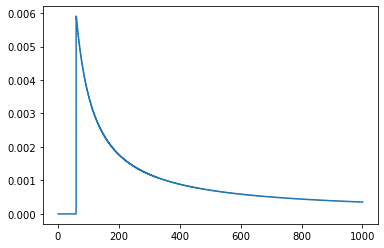

In [16]:
### fig = plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(*(posterior >> toSteps));

hmmm... that's quite a heavy tail...

In [17]:
[250, 500, 1000, 2000, 4000] >> each >> (lambda N: 
    (sequence(1, N) >> uniform) 
        >> pmfMul 
        >> railroadLikehood(N, data)
        >> normalise 
        >> mean
)

[132.8721992622349,
 207.0792279834104,
 333.41989326370776,
 552.1790171646376,
 936.5079113977753]

#### 3.4 An alternative prior

In fact, the distribution of company sizes tends to follow a power law, as Robert Axtell reports in Science (see http://www.sciencemag.org/content/293/5536/1818.full.pdf)

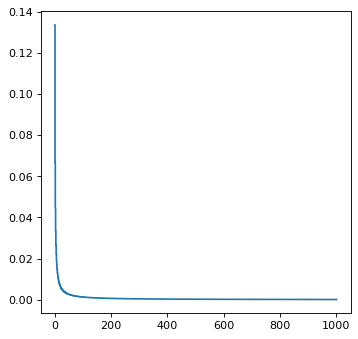

In [18]:
@coppertop
def powerLawPrior(n, alpha):
    return sequence(1, 1000) >> each >> (lambda hyp: (hyp, hyp**(-alpha))) >> to(_,adhoc) >> normalise

fig = plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(*(1000 >> powerLawPrior(_, 1) >> toSteps));

#### 3.5 Credible intervals

In [19]:
observations = [30, 60, 90]
Ns = [250, 500, 1000, 2000, 4000]

Ns >> each >> (lambda N: 
    powerLawPrior(N, 0.9)
        >> inject(observations, _, _) >> (lambda prior, ob:
            prior
                >> pmfMul 
                >> railroadLikehood(N, ob)
                >> normalise 
        )
        >> anon(lambda pmf: [pmf >> percentile(_,0.05), pmf >> mean, pmf >> percentile(_,0.95)])
)

[[91, 123.52471977274632, 199],
 [91, 132.31912378592563, 241],
 [91, 135.34103113413445, 250],
 [91, 135.34103113413445, 250],
 [91, 135.34103113413445, 250]]

IDEAL ERRORS

"hello" >> toCmf

```
Can't find toCmf(str) in:
  toCmf(pmf:(adhoc + (t514 & _numEtAl & _PMF))) in dm.pmf
```

ideally

```
DispatchError: Can't find toCmf(str) in:
  toCmf(pmf:PMF+adhoc) -> any    in dm.pmf[176]
---------------------------------------------------------------------------
Traceback (most recent call last)

<ipython-input-26-8a7f9c734ab9> in <module>
----> 1 "hello" >> toCmf
```